# Generative Adverserial Networks - Experiment 1

This experiment has to do with applying GANs to the gray-scale images of hand-written digits in the MNIST data set.
The full configuration (some of which not necessarily useful):
 - Python 3.6
 - Pythorch version 1.0.1
 - Torchvision version 0.2.2
 - Tensorflow version 1.13.1

In [66]:
"""
    References for the code snippets that are not mine:
    [1] https://github.com/diegoalejogm/gans/find/master
"""

%load_ext autoreload
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
%autoreload 2

from IPython import display

from utils import Logger
import gans

import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets

In [48]:
DATA_FOLDER = './torch_data/basic_gans/MNIST'

In [49]:
data = gans.fetch_mnist_data(DATA_FOLDER) # Fetching the data
data_loader = torch.utils.data.DataLoader(data, batch_size=100, shuffle=True)
n_batches = len(data_loader)  # The number of batches

In [50]:
discriminator = gans.Discriminator()
generator = gans.Generator()

if torch.cuda.is_available():  # Using GPUs if possible
    discriminator.cuda()
    generator.cuda()

## Optimization
For optimization, the commonly used method is the __mini-batch gradient descent algorithm__ for minimizing the loss function. We have already defined the batch size, and the rest of the configurations are specified below (more explanation is to be brought here.


### The Cross-entropy loss
Given that the true class for data point $\textbf{x}_n$ is $y_n$, the loss is defined as $l=-log(p_{y_n})$, where $p_{y_n}$ is the probability of the data point belonging to the true class $y_n$.

Please note that the gradient of the showd function w.r.t. $\theta_d$ should be ascended, while its the other way round for the gradient w.r.t. $\theta_g$. To be consistent, we consider label 1 for all the real images and 0 for the fake ones.

The gradients are computed as follows, where D and G are the output of the networks.

<img src="img/funcs.png">

In [51]:
# Using Adam for optimization (still need to read more about it)
# The learning rate is an arbitrary choice right now (need to read more)

d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

# The binary cross-entropy loss function
loss = nn.BCELoss()

Using the formulas for the functions that are going to be minimized/maximized and our loss function, it is straightforward to code those functions.

In [52]:
def train_discriminator(optimizer, real_data, fake_data):
    """
        The code is from [1] with small tweaks. The name of the value that is going to be maximized should not be
        loss, I believ, as naturally loss is a quantity which we try to minimize, while this is the other way round here.
    """
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)
    
    # Calculate error and backpropagate
    error_real = loss(prediction_real, gans.real_data_target(real_data.size(0)))
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, gans.fake_data_target(real_data.size(0)))
    error_fake.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Return error
    return error_real + error_fake, prediction_real, prediction_fake


def train_generator(optimizer, fake_data):
    """
        According to the paper: "Rather than minimizing log(1- D(G(z))),
        training the Generator to maximize log D(G(z)) will provide much stronger
        gradients early in training" (still should read about it).
    """
    # Reset gradients
    optimizer.zero_grad()
    
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)  # This is D(G(z_i)) for each z_i
    
    # Calculate error and backpropagate
    error = loss(prediction, gans.real_data_target(prediction.size(0)))
    error.backward()
    
    # Update weights with gradients
    optimizer.step()
    return error

## Generating samples and running

In [62]:
n_test_samples = 16  # The number of test samples
test_noise = gans.generate_noise(n_test_samples)

# Number of steps to apply to the discriminator, here is 1 for our simple experiment
d_steps = 1  # In Goodfellow et al. 2014 this variable is assigned to 1

# Number of epochs - iterations over the whole training data
n_epochs = 20

In [63]:
# gans.run_gan(generator, discriminator, data_loader, n_epochs=1)

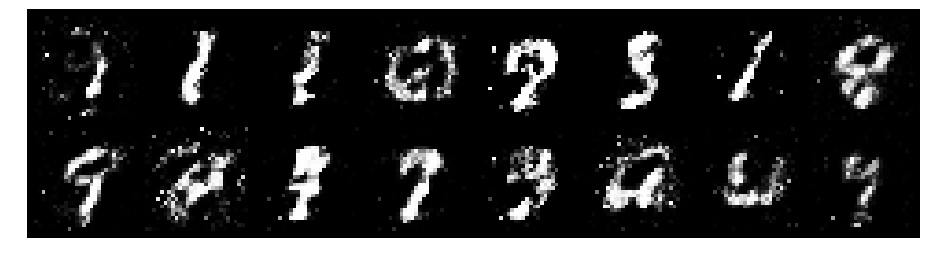

Epoch: [19/20], Batch Num: [500/600]
Discriminator Loss: 0.7911, Generator Loss: 2.0421
D(x): 0.6920, D(G(z)): 0.2177


In [65]:
logger = Logger(model_name='VGAN', data_name='MNIST')

for epoch in range(n_epochs):
    for n_batch, (real_batch,_) in enumerate(data_loader):

        # 1. Train Discriminator
        real_data = Variable(gans.images_to_vectors(real_batch))
        if torch.cuda.is_available(): real_data = real_data.cuda()
        
        # Generate fake data
        fake_data = generator(gans.generate_noise(real_data.size(0))).detach()
        
        # Train D
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer,
                                                                real_data, fake_data)

        
        
        # 2. Train Generator
        # Generate fake data
        fake_data = generator(gans.generate_noise(real_batch.size(0)))
        
        # Train G
        g_error = train_generator(g_optimizer, fake_data)
        
        # Log error
        logger.log(d_error, g_error, epoch, n_batch, n_batches)

        # Display Progress
        if (n_batch) % 100 == 0:
            display.clear_output(True)
            
            # Display Images
            test_images = gans.vectors_to_images(generator(test_noise)).data.cpu()
            logger.log_images(test_images, n_test_samples, epoch, n_batch, n_batches);
            
            # Display status Logs
            logger.display_status(
                epoch, n_epochs, n_batch, n_batches,
                d_error, g_error, d_pred_real, d_pred_fake
            )
        
        # Model Checkpoints
        logger.save_models(generator, discriminator, epoch)